In [4]:
import requests
from bs4 import BeautifulSoup as bs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import scipy.stats as sts

import warnings
warnings.filterwarnings("ignore")

# IV) Создаем новый признак

Для того чтобы определить страну производитель, было решено сначала разделить название на производителя и модель в исходном датасете, затем глянуть на производителей и создать словарь с производителями и странами

In [2]:
df = pd.read_csv('data_processed.csv')
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [3]:
df.insert(1, 'Марка', df['Название'].str.split(' ', 1, expand=True)[1])
df['Название'] = df['Название'].str.split(' ', 1, expand=True)[0]
df.rename(columns = {'Название': 'Производитель'}, inplace = True)

Путем поиска в интернетах создаем словарик...

In [4]:
slovar = {'Kia': 'Южная Корея', 'Hyundai': 'Южная Корея', 'Toyota': 'Япония', 'Jeep': 'США',
          'Mercedes-Benz': 'Германия', 'Лада': 'Россия', 'BMW': 'Германия','ГАЗ': 'Россия',
          'Changan': 'Китай', 'Infiniti': 'Япония', 'Audi': 'Германия', 'Volkswagen': 'Германия',
          'Great Wall': 'Китай', 'Honda': 'Япония', 'Nissan': 'Япония', 'SsangYong': 'Южная Корея', 
          'Skoda': 'Чехия', 'Volvo': 'Швеция', 'Land Rover': 'Британия', 'Chevrolet': 'США',
          'Mazda': 'Япония', 'Opel': 'Германия', 'Peugeot': 'Франция', 'Rivian': 'США',
          'Renault': 'Франция', 'Mitsubishi': 'Япония', 'Tesla': 'США', 'Lexus': 'Япония',
          'Ford': 'США', 'Bentley': 'Британия', 'Subaru': 'Япония', 'Porsche': 'Германия',
          'Dodge': 'США', 'Fiat': 'Италия', 'Suzuki': 'Япония', 'Haval': 'Китай', 'УАЗ': 'Россия',
          'Geely': 'Китай', 'Chery': 'Китай', 'EXEED': 'Китай', 'Genesis': 'Южная Корея',
          'Dongfeng': 'Китай', 'Citroen': 'Германия', 'BYD': 'Китай', 'Jaguar': 'Британия',
          'Tank': 'Китай', 'ЗАЗ': 'Россия', 'Daewoo': 'Южная Корея', 'Kaiyi': 'Китай',
          'MINI': 'Британия', 'Datsun': 'Япония', 'Москвич': 'Россия', 'SEAT': 'Испания',
          'Cadillac': 'США', 'Daihatsu': 'Япония', 'Voyah': 'Китай', 'GMC': 'США', 'Chrysler': 'США',
          'Lifan': 'Китай', 'Isuzu': 'Япония', 'Ferrari': 'Италия', 'Smart': 'Германия',
          'Evolute': 'Россия', 'RAM': 'США', 'Maybach': 'Германия'}

Во время сбора словарика были найдены производители с названием из двух и более слов: Land Rover, Great Wall. Заменим их модели и название производителей.

Более того, была найдена машина Jetta совместного производства Китая и Volkswagen. Так как это пилотный проект, то было решено вообще выкинуть этот мусор

In [5]:
df.set_index('Производитель', inplace=True)
df.drop('Jetta', inplace=True)
df.rename(index = {'Great': 'Great Wall', 'Land': 'Land Rover'}, inplace=True)
df.reset_index(inplace = True)

for i in df[df['Производитель'] == 'Land Rover']['Марка'].values:
    df.replace(i, i.replace('Rover ', '', 1), inplace=True)
    
for i in df[df['Производитель'] == 'Great Wall']['Марка'].values:
    df.replace(i, i.replace('Wall ', '', 1), inplace=True)

countries = []
for i in list(df['Производитель'].values):
    countries.append(slovar[i])
df.insert(2, 'Страна', countries)


In [6]:
df.to_csv('new_data_processed.csv')

# V) Проверка гипотез

## Среднее значение цен на западные автомобили равно среднему значению цен на восточные

Приступим к проверке гипотезы. То есть:

$$
\begin{aligned}
&H_0:  \mu(восток)\ = \mu(запад)\\
&H_1:  \mu(восток)\ \not=\ \mu(запад)\\
\end{aligned}
$$

Рассмотрим, что относится к западу и востоку

In [7]:
df['Страна'].unique()

array(['Южная Корея', 'Япония', 'США', 'Германия', 'Россия', 'Китай',
       'Чехия', 'Швеция', 'Британия', 'Франция', 'Италия', 'Испания'],
      dtype=object)

In [8]:
west = np.array(['США', 'Германия', 'Чехия', 'Швеция', 'Британия', 'Франция', 'Италия', 'Испания'])
east = ['Южная Корея', 'Япония', 'Россия', 'Китай']

Проверим распределение цен автомобилей

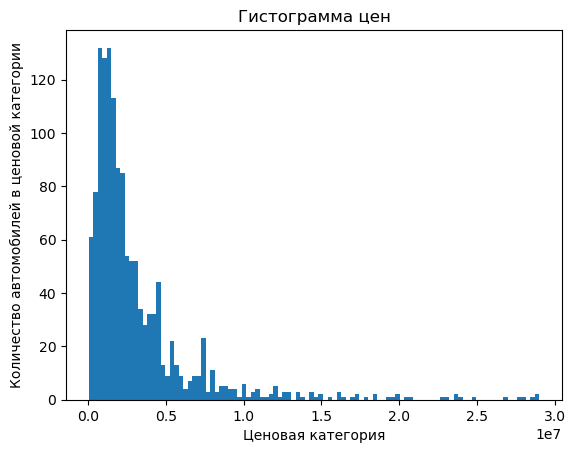

In [9]:
plt.hist(df['Цена'], bins=100)
plt.title('Гистограмма цен')
plt.xlabel('Ценовая категория')
plt.ylabel('Количество автомобилей в ценовой категории');

Гистограмма очень похожа на хи квадрат, который в ассимптотике сможет дать нормальное распределение, поэтому воспользуюсь этим свойством для проверки гипотезы.

Я не знаю истинную дисперсию, поэтому воспользовался ее несмещенной оценкой..

Рассматривался уровень доверия 95%

In [10]:
idx_w = []
idx_e = []
for i in df['Страна']:
    if i in west:
        idx_w.append(True)
        idx_e.append(False)
    else:
        idx_w.append(False)
        idx_e.append(True)

df_w = df[idx_w]
df_e = df[idx_e]

sigma = np.sqrt((df_e['Цена'].var(ddof=1) * (df_e.size - 1) + df_w['Цена'].var(ddof=1) * (df_w.size - 1)) 
 / (df_w.size + df_e.size - 2))

t_rasch = (df_w['Цена'].mean() - df_e['Цена'].mean()) / (sigma * np.sqrt((1 / df_e.size) + (1 / df_w.size)))
t_kr = sts.t(df = df_e.size + df_w.size - 2).ppf(0.05/2)


In [11]:
sigma = np.sqrt((df_e['Цена'].var(ddof=1) * (df_e.size - 1) + df_w['Цена'].var(ddof=1) * (df_w.size - 1)) 
 / (df_w.size + df_e.size - 2))

t_rasch = (df_w['Цена'].mean() - df_e['Цена'].mean()) / (sigma * np.sqrt((1 / df_e.size) + (1 / df_w.size)))
t_kr = sts.t(df = df_e.size + df_w.size - 2).ppf(0.05/2)

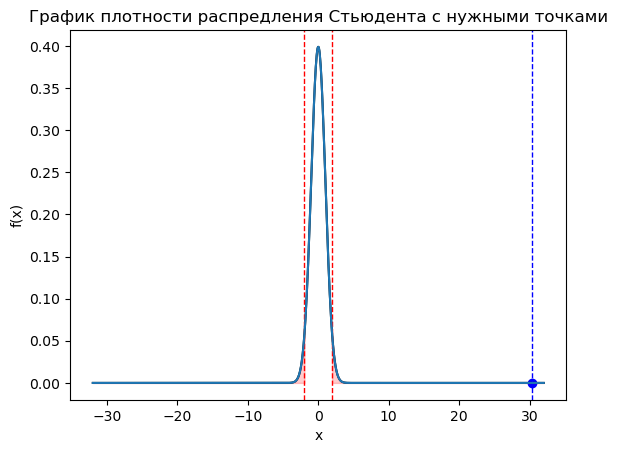

In [12]:
x = np.linspace(-32, 32, 1000)
pdf = sts.t(df=df_e.size + df_w.size - 2).pdf(x)
plt.plot(x, pdf, color = 'black')

plt.scatter(t_rasch, [sts.t(df=df_e.size + df_w.size - 2).pdf(t_rasch)], color="blue")
plt.axvline(t_rasch, color='blue', linestyle="--", lw=1)

plt.axvline(t_kr, color='red', linestyle="--", lw=1)
xq = np.linspace(-32, t_kr, 100)
yq = sts.t(df=df_e.size + df_w.size - 2).pdf(xq)
plt.fill_between(xq, 0, yq, color='red', alpha=0.2)

plt.axvline(-1 * t_kr, color='red', linestyle="--", lw=1)
xq = np.linspace(-1 * t_kr, 32, 100)
yq = sts.t(df=df_e.size + df_w.size - 2).pdf(xq)
plt.fill_between(xq, 0, yq, color='red', alpha=0.2)

plt.plot(x, pdf)
plt.ylabel('f(x)')
plt.xlabel('x')
plt.title('График плотности распредления Стьюдента с нужными точками');

In [13]:
print('Расчетная точка:',  t_rasch)
print('Критические точки: ',  -1 * t_kr, ', ', t_kr, sep='')

Расчетная точка: 30.34321831511047
Критические точки: 1.960087961271559, -1.960087961271559


Собственного говоря, гипотеза отвергается. Это видно и по графику выше

> Гипотез много. Например, выше, во время обработки данных и EDA я заметил раритетную машину 1950 года. Интересно, она одна такая? Или их значимое количество, если поискать? 

## Может ли цена зависеть от года выпуска прямо - чем меньше год выпуска, т.е. старее машина - тем выше цена?

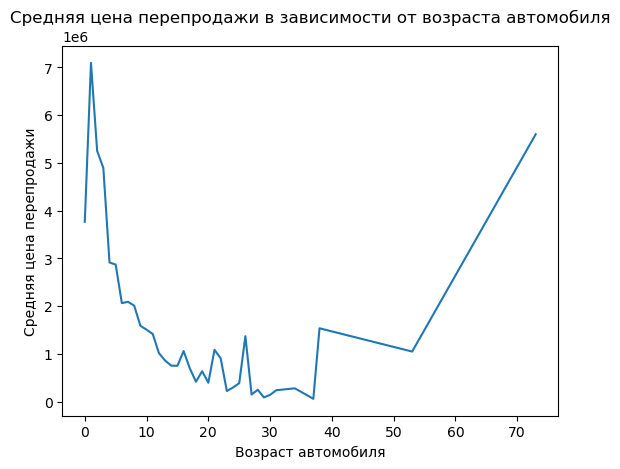

In [14]:
df['Год'] = pd.to_numeric(df['Год'])

# Создание нового столбца 'Возраст'
current_year = 2023  # Текущий год
df['Возраст'] = current_year - df['Год']

# Группировка данных по возрасту автомобилей и вычисление средней цены для каждой группы
age_price = df.groupby('Возраст')['Цена'].mean()

# Построение графика для визуализации результатов
plt.plot(age_price.index, age_price.values)
plt.xlabel('Возраст автомобиля')
plt.ylabel('Средняя цена перепродажи')
plt.title('Средняя цена перепродажи в зависимости от возраста автомобиля')
plt.show()

In [15]:
df.loc[df.Возраст > 35].head()

,Производитель,Марка,Страна,Год,Топливо,Объем двигателя,Мощность,Коробка передач,Привод,Цвет,Пробег,Руль,Оценка Drom,Цена,Возраст
12,ГАЗ,14 Чайка,Россия,1985,бензин,5.5,220.0,автомат,задний,черный,39316.0,левый,8.602,3000000,38
161,Лада,2101,Россия,1986,бензин,1.3,64.0,механика,задний,бежевый,100000.0,левый,7.500,60000,37
543,Лада,4x4 2121 Нива,Россия,1987,бензин,1.6,73.0,механика,4WD,бежевый,69000.0,левый,8.602,152000,36
548,Лада,2102,Россия,1985,бензин,1.6,64.0,механика,задний,бежевый,99999.0,левый,8.602,75000,38
885,BMW,340,Германия,1950,бензин,2.0,55.0,механика,задний,черный,50000.0,левый,8.602,5600000,73


> Что ж, немолодых автомобилей оказалось не так много, как хотелось бы, но учитывая, что на 3 машины из 5 имеющихся возрастом сташе 35 лет стоимость больше миллиона и на графике четко видно, что она растет с возрастом - данная зависимость имеет место быть.

Хорошо, но можно ли говорить, что цена автомобиля обусловлена его возрастом, пробегом и прочими факторами, но при этом в целом не так то и важно, какая марка машины это изначально была?

In [16]:
brand_price = df.groupby('Производитель')['Цена'].mean()

# Выполнение однофакторного ANOVA
fvalue, pvalue = sts.f_oneway(*[group['Цена'] for brand, group in df.groupby('Производитель')])

# Вывод результатов
print("F-значение:", fvalue)
print("p-value:", pvalue)

F-значение: 12.02950298125449
p-value: 9.934432508238841e-92


Кажется, нет. Из-за большого F-значения можно утверждать, что марка авто значительно влияет на его цену, а столь маленький p-value (e-92!!!!) говорит о том, что ошибка тут явно исключена

# VI) Построение моделей

Модели будут предсказывать цену автомобиля

## Линейная регрессия

In [98]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from catboost import Pool, cv

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV

In [44]:
def rmse_score(true, pred):
    return np.sqrt(mean_squared_error(true, pred))

In [45]:
df = pd.read_csv('new_data_processed.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)

In [46]:
#Только числовые немасштабированные данные 

df_1 = df[['Год', 'Объем двигателя', 'Мощность', 'Пробег', 'Оценка Drom', 'Цена']]
df_train, df_test = train_test_split(df_1, test_size=0.2, random_state=101)

y_train_num = df_train['Цена']
y_test_num = df_test['Цена']

X_train_num = df_train.drop('Цена', axis=1)
X_test_num = df_test.drop('Цена', axis=1)

X_num = df_1.drop('Цена', axis=1)
y_num = df_1['Цена']

In [47]:
#Масштабированные числовые признаки

scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train_num)
X_test_scale = scaler.transform(X_test_num)

In [48]:
#Категориальные признаки

numeric_features = df.select_dtypes([np.number]).columns
categorical_features = df.dtypes[df.dtypes == "object"].index

encoder = OneHotEncoder(drop="first", sparse=False, handle_unknown='ignore')
df_cat_ohe = pd.DataFrame(encoder.fit_transform(df[categorical_features]), 
                          columns = encoder.get_feature_names_out(categorical_features))

df_all = pd.concat([df[numeric_features], df_cat_ohe], axis = 1)

df_train, df_test = train_test_split(df_all, test_size=0.2, random_state=101)

y_train_cat = df_train['Цена']
y_test_cat = df_test['Цена']

X_train_cat = df_train.drop('Цена', axis=1)
X_test_cat = df_test.drop('Цена', axis=1)

X_cat = df_all.drop('Цена', axis = 1)
y_cat = df_all['Цена']

### Классическая линейная регрессия

In [49]:
model = LinearRegression()

model.fit(X_train_num, y_train_num)
y_pr = model.predict(X_test_num)
y_train_pred = model.predict(X_train_num)

print("Test RMSE = %.4f" % rmse_score(y_test_num, y_pr))
print("Train RMSE = %.4f" % rmse_score(y_train_num, y_train_pred))

cross_val = cross_val_score(model, X_num, y_num, scoring='neg_root_mean_squared_error')
rmse = np.mean(-1 * cross_val)
print("\nRMSE cross_val:", rmse)

Test RMSE = 2449187.3553
Train RMSE = 2385901.7710

RMSE cross_val: 2412789.0238631465


__Наивный прогноз__

In [50]:
y_naive_pred = np.mean(y_train_num) * np.ones_like(y_test_num)
rmse_score(y_naive_pred, y_pr)

2790260.307230077

Модель предсказывает лучше, чем наивный проноз, но метрики все равно плохи...

### Отмасштабированная линейная регрессия

In [51]:
model.fit(X_train_scale, y_train_num)
y_pr_ss = model.predict(X_test_scale)
y_train_pr_ss = model.predict(X_train_scale)

print("Test RMSE = %.4f" % rmse_score(y_test_num, y_pr_ss))
print("Train RMSE = %.4f" % rmse_score(y_train_num, y_train_pr_ss))


simple_pipeline = Pipeline(steps=[
    ('SS', StandardScaler()),
    ('regression', LinearRegression())
])

scores = cross_val_score(simple_pipeline, X_num, y_num, scoring='neg_root_mean_squared_error', cv=5)
rmse = np.mean(-1 * scores)

print("\nRMSE cross_val:", rmse)

Test RMSE = 2449187.3553
Train RMSE = 2385901.7710

RMSE cross_val: 2412789.023863147


Скалирование ничего не изменило... Добавим категориальные признаки

### Линейная регрессия с категориальными признаками

In [52]:
Linear_pipeline = Pipeline(steps=[
    ('scaling', StandardScaler()),
    ('regression', LinearRegression())
])

model = Linear_pipeline.fit(X_train_cat, y_train_cat)
y_pred = model.predict(X_test_cat)
y_train_pred = model.predict(X_train_cat)

print("Test RMSE = %.4f" % rmse_score(y_test_cat, y_pred))
print("Train RMSE = %.4f" % rmse_score(y_train_cat, y_train_pred))


scores = cross_val_score(Linear_pipeline, X_cat, y_cat, scoring='neg_root_mean_squared_error', cv=5)
rmse = np.mean(-1 * scores)

print("\nRMSE cross_val:", rmse)

Test RMSE = 299902269852520087552.0000
Train RMSE = 2653830.2554

RMSE cross_val: 1.8642591168004784e+20


Так как категориальные переменные раздули донельзя датасет, применим Lasso - регрессию, чтобы выбросить "плохие" признаки

### Регуляризация

In [53]:
Lasso_pipeline = Pipeline(steps=[
    ('scaling', StandardScaler()),
    ('regression', Lasso())
])

model_lasso = Lasso_pipeline.fit(X_train_cat, y_train_cat)
y_pred = model_lasso.predict(X_test_cat)
y_train_pred = model_lasso.predict(X_train_cat)


print("Test RMSE = %.4f" % rmse_score(y_test_cat, y_pred))
print("Train RMSE = %.4f" % rmse_score(y_train_cat, y_train_pred))


scores = cross_val_score(Lasso_pipeline, X_cat, y_cat, scoring='neg_root_mean_squared_error', cv=5)
rmse = np.mean(-1 * scores)

print("\nRMSE cross_val:", rmse)

Test RMSE = 2441961.4014
Train RMSE = 1466213.1635

RMSE cross_val: 2341549.334979023


Лассо помогло снизить переобучение. Попробуем подобрать альфу через гридсерч

In [54]:
alphas = np.linspace(0, 1, 20)
searcher = GridSearchCV(Lasso_pipeline, [{"regression__alpha": alphas}],
                        scoring="neg_root_mean_squared_error", cv=5)
searcher.fit(X_train_cat, y_train_cat)

best_alpha = searcher.best_params_["regression__alpha"]

pipeline = Pipeline(steps=[
    ('scaling', StandardScaler()),
    ('regression', Lasso(best_alpha))
])

model_lasso = pipeline.fit(X_train_cat, y_train_cat)
y_pred = model_lasso.predict(X_test_cat)
y_train_pred = model_lasso.predict(X_train_cat)

print("Test RMSE = %.4f" % rmse_score(y_test_cat, y_pred))
print("Train RMSE = %.4f" % rmse_score(y_train_cat, y_train_pred))
print('\nBest alpha:', best_alpha)
print('\nRMSE cross_cal', -1 * searcher.best_score_)

Test RMSE = 2441961.4014
Train RMSE = 1466213.1635

Best alpha: 1.0

RMSE cross_cal 2324897.95705208


In [55]:
print('Число ненужных параметров:', 
      sum(model_lasso['regression'].coef_ == 0), 'из', 
      len(model_lasso['regression'].coef_))

Число ненужных параметров: 61 из 503


In [133]:
best_par = X_train_cat.columns[model_lasso['regression'].coef_ == model_lasso['regression'].coef_.max()][0]
print(f'Наиболее важный параметр: {best_par}')

Наиболее важный параметр: Мощность


Закончим с регрессиями и посмотрим на другие модели

## Метод ближайших соседей

### Классический kNN

In [56]:
model = KNeighborsClassifier(n_neighbors=10, p=2, weights='distance')

model.fit(X_train_num, y_train_num)
y_pr = model.predict(X_test_num)
y_train_pred = model.predict(X_train_num)

print("Test RMSE = %.4f" % rmse_score(y_test_num, y_pr))
print("Train RMSE = %.4f" % rmse_score(y_train_num, y_train_pred))

cross_val = cross_val_score(model, X_num, y_num, scoring='neg_root_mean_squared_error')
rmse = np.mean(-1 * cross_val)
print("\nRMSE cross_val:", rmse)

Test RMSE = 3000269.6268
Train RMSE = 221365.3099

RMSE cross_val: 2868906.9510235693


Проделаем все, что делали выше для линейной регрессии

### kNN со скалированными данными

In [57]:
model.fit(X_train_scale, y_train_num)
y_pr_ss = model.predict(X_test_scale)
y_train_pr_ss = model.predict(X_train_scale)

print("Test RMSE = %.4f" % rmse_score(y_test_num, y_pr_ss))
print("Train RMSE = %.4f" % rmse_score(y_train_num, y_train_pr_ss))

X = df_1.drop('Цена', axis=1)
y = df_1['Цена']

knn_pipeline = Pipeline(steps=[
    ('SS', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=10, p=2, weights='distance'))
])

scores = cross_val_score(knn_pipeline, X_num, y_num, scoring='neg_root_mean_squared_error', cv=5)
rmse = np.mean(-1 * scores)

print("\nRMSE cross_val:", rmse)

Test RMSE = 1793132.9592
Train RMSE = 221365.3099

RMSE cross_val: 1891642.1446624529


Очевидно, стандартизация очень сильно помогла ближайшим соседям. Попробую добавить категориальные переменные

### kNN с категориальными данными

In [58]:
KNN_pipeline = Pipeline(steps=[
    ('scaling', StandardScaler()),
    ('KNN', KNeighborsClassifier(2))
])

model = KNN_pipeline.fit(X_train_cat, y_train_cat)
y_pred = model.predict(X_test_cat)
y_train_pred = model.predict(X_train_cat)

print("Test RMSE = %.4f" % rmse_score(y_test_cat, y_pred))
print("Train RMSE = %.4f" % rmse_score(y_train_cat, y_train_pred))

scores = cross_val_score(KNN_pipeline, X_cat, y_cat, scoring='neg_root_mean_squared_error', cv=5)
rmse = np.mean(-1 * scores)

print("\nRMSE cross_val:", rmse)

Test RMSE = 3428668.4866
Train RMSE = 2002061.4075

RMSE cross_val: 3024650.136194841


Уберем лишние признаки согласно модели Lasso

In [59]:
df_lasso = pd.concat([X_cat[X_cat.columns[model_lasso['regression'].coef_ != 0]], y], axis = 1)

df_train, df_test = train_test_split(df_lasso, test_size=0.2, random_state=101)

y_train = df_train['Цена']
y_test = df_test['Цена']

X_train = df_train.drop('Цена', axis=1)
X_test = df_test.drop('Цена', axis=1)

KNN_pipeline = Pipeline(steps=[
    ('scaling', StandardScaler()),
    ('KNN', KNeighborsClassifier(2))
])

model = KNN_pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

print("Test RMSE = %.4f" % rmse_score(y_test, y_pred))
print("Train RMSE = %.4f" % rmse_score(y_train, y_train_pred))

scores = cross_val_score(KNN_pipeline, df_lasso, y, scoring='neg_root_mean_squared_error', cv=5)
rmse = np.mean(-1 * scores)

print("\nRMSE cross_val:", rmse)

Test RMSE = 3428668.4866
Train RMSE = 2058974.0689

RMSE cross_val: 2384687.502201992


## Случайный лес

Так как не имеет смысла рассматривать все наборы признаков, оставим два наиболее логичных:
- Числовые отмасштабированные признаки;
- Числовые отмасштабированные признаки + отобранные закодированные категориальные признаки


Как известно, решающее дерево и случайный лес могут принимать на вход незакодированные категориальные признаки, однако в таком случае будет несколько больше сплитов. Чтобы ускорить процесс обучения, будем подавать закодированные признаки

### Модель с отскалированными числовыми признаками

In [26]:
rfr_pipeline = Pipeline(steps=[
    ('SS', StandardScaler()),
    ('RFR', RandomForestRegressor(random_state=42))
])

params = {'RFR__n_estimators': np.arange(1, 20, 3),
          'RFR__criterion': ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
          'RFR__max_depth': np.arange(1, 36, 1)}

grid = GridSearchCV(rfr_pipeline, param_grid=params, scoring='neg_root_mean_squared_error', cv = 5)
grid.fit(X_train_num, y_train_num)
print(f'RMSE {-1 * grid.best_score_}')

RMSE 1513019.9060417782


In [39]:
model = grid.best_estimator_
model.fit(X_train_scale, y_train_num)

y_pr_test = model.predict(X_test_scale)
y_pr_train = model.predict(X_train_scale)

print("Test RMSE = %.4f" % rmse_score(y_test_num, y_pr_test))
print("Train RMSE = %.4f" % rmse_score(y_train_num, y_pr_train))

Test RMSE = 1686771.7154
Train RMSE = 708091.3885


### Модель с категориальными признаками

In [115]:
RFR_pipeline = Pipeline(steps=[
    ('scaling', StandardScaler()),
    ('RFR', model)
])

RFR_pipeline.fit(X_train, y_train_cat)

y_pr_test = RFR_pipeline.predict(X_test)
y_pr_train = RFR_pipeline.predict(X_train)

print("Test RMSE = %.4f" % rmse_score(y_test, y_pr_test))
print("Train RMSE = %.4f" % rmse_score(y_train, y_pr_train))

scores = cross_val_score(RFR_pipeline, df_lasso, y, scoring='neg_root_mean_squared_error', cv=5)
rmse = np.mean(-1 * scores)

print("\nRMSE cross_val:", rmse)

Test RMSE = 1440099.9345
Train RMSE = 637070.9761

RMSE cross_val: 179393.34077576734


Категориальные признаки только ухудшили качество модели и степень переобучения, поэтому для деревьев оказался более полезным числовой набор признаков, более того эта модель лучшая из рассмотренных ранее

## Градиентный бустинг

### Модель с числовыми признаками 

In [100]:
model = CatBoostRegressor(iterations=10000, 
                          depth=2, 
                          learning_rate=0.01, 
                          loss_function='RMSE',
                          verbose=False)

model.fit(X_train_num, y_train_num)

y_pr_test = model.predict(X_test_num)
y_pr_train = model.predict(X_train_num)

print("Test RMSE = %.4f" % rmse_score(y_test_num, y_pr_test))
print("Train RMSE = %.4f" % rmse_score(y_train_num, y_pr_train))

cv_num = cv(pool=Pool(X_num, label=y_num),
                      params=model.get_params(), 
                      fold_count=5,
                      verbose=False)

rmse = cv_num['test-RMSE-mean']

print("CV RMSE = %.4f" % np.mean(rmse))

Test RMSE = 1655363.9973
Train RMSE = 934453.8240
Training on fold [0/5]

bestTest = 1425080.727
bestIteration = 4561

Training on fold [1/5]

bestTest = 1602002.948
bestIteration = 2811

Training on fold [2/5]

bestTest = 1511538.864
bestIteration = 9962

Training on fold [3/5]

bestTest = 1547572.772
bestIteration = 7960

Training on fold [4/5]

bestTest = 1425730.057
bestIteration = 4895

CV RMSE = 1602154.2970


### Модель с категориальными признаками

In [116]:
model = CatBoostRegressor(iterations=10000, 
                          depth=2, 
                          learning_rate=0.01, 
                          loss_function='RMSE',
                          verbose=False)

model.fit(X_train, y_train)

y_pr_test = model.predict(X_test)
y_pr_train = model.predict(X_train)

print("Test RMSE = %.4f" % rmse_score(y_test, y_pr_test))
print("Train RMSE = %.4f" % rmse_score(y_train, y_pr_train))

cv_cat = cv(pool=Pool(df_lasso, label=y),
                      params=model.get_params(), 
                      fold_count=5,
                      verbose=False)

rmse = cv_cat['test-RMSE-mean']

print("CV RMSE = %.4f" % np.mean(rmse))

Test RMSE = 1440082.6574
Train RMSE = 637070.9761
Training on fold [0/5]

bestTest = 182670.3485
bestIteration = 9997

Training on fold [1/5]

bestTest = 111542.6492
bestIteration = 7472

Training on fold [2/5]

bestTest = 130930.112
bestIteration = 1004

Training on fold [3/5]

bestTest = 113707.3042
bestIteration = 9970

Training on fold [4/5]

bestTest = 144773.3641
bestIteration = 5915

CV RMSE = 211657.7678


Модель на тестовой и тренировочной выборках показала примерно аналогичный результат, как и лес на более важных признаках, однако RMSE на кросс-валидации оказался меньше в разы.

# Выводы

Большинство выводов было сделано в ходе исследования.

Лучшая модель на данный момент исследования оказался лес со скалированными числовыми признаками. Его метрики:
- Test RMSE = 1686771.7154		
- Train RMSE = 708091.3885		
		
- CV RMSE 1513019.9060

Очевидно, что это довольно большие значения для задачи, однако это объясняется свойствами данных. В датасете представлены, как раритетные автомобили с большими ценами (что не может быть просто объяснено моделями), так и автомобили премиум-сегмента, которые по свойствам могут не отличаться от более дешевых аналогов

# Будущее

В дальнейшем хочется разбить датасет на некоторые категории автомобилей (премиум-сегмент, раритетное авто и т.д.), вероятнее всего, это будет сделано с помощью решающего дерева или ансамбля. 

Работа с такими категорями должна кратно улучшить метрики за счет создания сразу нескольких моделей под каждую категорию. 

Кроме этого в планах разработать полносвязную нейронную сеть для набора данных